0. Colab setup & GPU

In [9]:

!pip -q install -U tensorflow tensorflow-datasets matplotlib seaborn


# Runtime -> Change runtime type -> GPU for faster training
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.20.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


1. Imports & reproducibility

In [10]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
from sklearn.metrics import confusion_matrix, classification_report


RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)


# Training parameters
IMG_SIZE = 224 # MobileNetV2 / ResNet50 common input size
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

2. Dataset Loading

In [11]:
# Load TFDS Cats vs Dogs and split
(ds_train, ds_val, ds_test), ds_info = tfds.load(
'cats_vs_dogs',
split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
as_supervised=True,
with_info=True
)


print(ds_info)

tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    full_name='cats_vs_dogs/4.0.1',
    description="""
    A large set of images of cats and dogs. There are 1738 corrupted images that are dropped.
    """,
    homepage='https://www.microsoft.com/en-us/download/details.aspx?id=54765',
    data_dir='/root/tensorflow_datasets/cats_vs_dogs/4.0.1',
    file_format=tfrecord,
    download_size=786.67 MiB,
    dataset_size=1.04 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/filename': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    nondeterministic_order=False,
    splits={
        'train': <SplitInfo num_examples=23262, num_shards=16>,
    },
    citation="""@Inproceedings (Conference){asirra-a-captcha-that-exploits-interest-aligned-manual-image-categorization,
    author = {Elson, Jeremy and Douceur, Jo

3. Preprocessing & augmentation

In [12]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input


data_augmentation = keras.Sequential(
[
layers.RandomFlip('horizontal'),
layers.RandomRotation(0.1),
layers.RandomZoom(0.1),
layers.RandomContrast(0.1),
], name='data_augmentation'
)

4. Format TFDS

In [13]:
def format_and_preprocess(image, label):
   image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
   image = tf.cast(image, tf.float32)
   image = preprocess_input(image) # scale to expected range for MobileNetV2
   label = tf.cast(label, tf.int32)
   return image, label


# Apply for TFDS pipelines
train_ds = ds_train.map(format_and_preprocess, num_parallel_calls=AUTOTUNE)
val_ds = ds_val.map(format_and_preprocess, num_parallel_calls=AUTOTUNE)
test_ds = ds_test.map(format_and_preprocess, num_parallel_calls=AUTOTUNE)


# Shuffle, batch, prefetch
train_ds = train_ds.shuffle(1000).batch(BATCH_SIZE).prefetch(AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

5. Build the transfer learning model (MobileNetV2)

In [14]:
base_model = tf.keras.applications.MobileNetV2(
input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet'
)
base_model.trainable = False # freeze the base for initial training


inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
# optional: include augmentation only during training
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
# Binary classification -> 1 unit sigmoid. For multi-class change accordingly.
outputs = layers.Dense(1, activation='sigmoid')(x)


model = keras.Model(inputs, outputs)
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

6. Compile & callbacks

In [15]:
initial_lr = 1e-3
model.compile(
optimizer=keras.optimizers.Adam(learning_rate=initial_lr),
loss='binary_crossentropy',
metrics=['accuracy']
)


callbacks = [
keras.callbacks.ModelCheckpoint('best_transfer_model.h5', save_best_only=True, monitor='val_loss'),
keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3)
]
# Optional: CSV logger for training logs
csv_logger = keras.callbacks.CSVLogger('training_log.csv')
callbacks.append(csv_logger)

7. Train top layers (head) first

In [16]:
initial_epochs = 5
history_head = model.fit(
train_ds,
epochs=initial_epochs,
validation_data=val_ds,
callbacks=callbacks
)

Epoch 1/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.8080 - loss: 0.3892

582/582 ━━━━━━━━━━━━━━━━━━━━ 66s 80ms/step - accuracy: 0.8081 - loss: 0.3891 - val_accuracy: 0.9768 - val_loss: 0.0774 - learning_rate: 0.0010
Epoch 2/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 69s 75ms/step - accuracy: 0.8764 - loss: 0.2777 - val_accuracy: 0.9781 - val_loss: 0.0780 - learning_rate: 0.0010
Epoch 3/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.8783 - loss: 0.2749

582/582 ━━━━━━━━━━━━━━━━━━━━ 52s 87ms/step - accuracy: 0.8783 - loss: 0.2749 - val_accuracy: 0.9807 - val_loss: 0.0662 - learning_rate: 0.0010
Epoch 4/5
581/582 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.8834 - loss: 0.2676

582/582 ━━━━━━━━━━━━━━━━━━━━ 53s 89ms/step - accuracy: 0.8834 - loss: 0.2676 - val_accuracy: 0.9807 - val_loss: 0.0661 - learning_rate: 0.0010
Epoch 5/5
581/582 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.8793 - loss: 0.2676

582/582 ━━━━━━━━━━━━━━━━━━━━ 46s 76ms/step - accuracy: 0.8793 - loss: 0.2676 - val_accuracy: 0.9794 - val_loss: 0.0631 - learning_rate: 0.0010


8. Fine-tuning: unfreeze some of the base model

In [18]:
# Unfreeze from a certain layer onward (fine-tune top layers)
base_model.trainable = True
fine_tune_at = int(len(base_model.layers) * 0.8) # unfreeze top 20%
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
for layer in base_model.layers[fine_tune_at:]:
    layer.trainable = True


# Recompile with lower LR
model.compile(
optimizer=keras.optimizers.Adam(learning_rate=1e-5),
loss='binary_crossentropy',
metrics=['accuracy']
)


fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs
history_fine = model.fit(
train_ds,
epochs=total_epochs,
initial_epoch=history_head.epoch[-1] + 1 if hasattr(history_head, 'epoch') else initial_epochs,
validation_data=val_ds,
callbacks=callbacks
)

Epoch 6/15
582/582 ━━━━━━━━━━━━━━━━━━━━ 69s 95ms/step - accuracy: 0.8198 - loss: 0.3942 - val_accuracy: 0.9751 - val_loss: 0.0690 - learning_rate: 1.0000e-05
Epoch 7/15
582/582 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.8951 - loss: 0.2427

582/582 ━━━━━━━━━━━━━━━━━━━━ 81s 96ms/step - accuracy: 0.8951 - loss: 0.2427 - val_accuracy: 0.9798 - val_loss: 0.0547 - learning_rate: 1.0000e-05
Epoch 8/15
581/582 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9010 - loss: 0.2295

582/582 ━━━━━━━━━━━━━━━━━━━━ 58s 96ms/step - accuracy: 0.9010 - loss: 0.2295 - val_accuracy: 0.9811 - val_loss: 0.0528 - learning_rate: 1.0000e-05
Epoch 9/15
582/582 ━━━━━━━━━━━━━━━━━━━━ 57s 95ms/step - accuracy: 0.9105 - loss: 0.2065 - val_accuracy: 0.9776 - val_loss: 0.0560 - learning_rate: 1.0000e-05
Epoch 10/15
582/582 ━━━━━━━━━━━━━━━━━━━━ 55s 93ms/step - accuracy: 0.9150 - loss: 0.1974 - val_accuracy: 0.9781 - val_loss: 0.0552 - learning_rate: 1.0000e-05
Epoch 11/15
582/582 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.9206 - loss: 0.1842

582/582 ━━━━━━━━━━━━━━━━━━━━ 57s 93ms/step - accuracy: 0.9206 - loss: 0.1842 - val_accuracy: 0.9819 - val_loss: 0.0498 - learning_rate: 1.0000e-05
Epoch 12/15
582/582 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9179 - loss: 0.1860

582/582 ━━━━━━━━━━━━━━━━━━━━ 56s 95ms/step - accuracy: 0.9179 - loss: 0.1860 - val_accuracy: 0.9832 - val_loss: 0.0498 - learning_rate: 1.0000e-05
Epoch 13/15
582/582 ━━━━━━━━━━━━━━━━━━━━ 58s 97ms/step - accuracy: 0.9257 - loss: 0.1733 - val_accuracy: 0.9759 - val_loss: 0.0603 - learning_rate: 1.0000e-05
Epoch 14/15
582/582 ━━━━━━━━━━━━━━━━━━━━ 57s 95ms/step - accuracy: 0.9320 - loss: 0.1642 - val_accuracy: 0.9802 - val_loss: 0.0556 - learning_rate: 1.0000e-05
Epoch 15/15
582/582 ━━━━━━━━━━━━━━━━━━━━ 55s 92ms/step - accuracy: 0.9376 - loss: 0.1540 - val_accuracy: 0.9819 - val_loss: 0.0532 - learning_rate: 2.0000e-06


9. Plot training history (head + fine-tune)

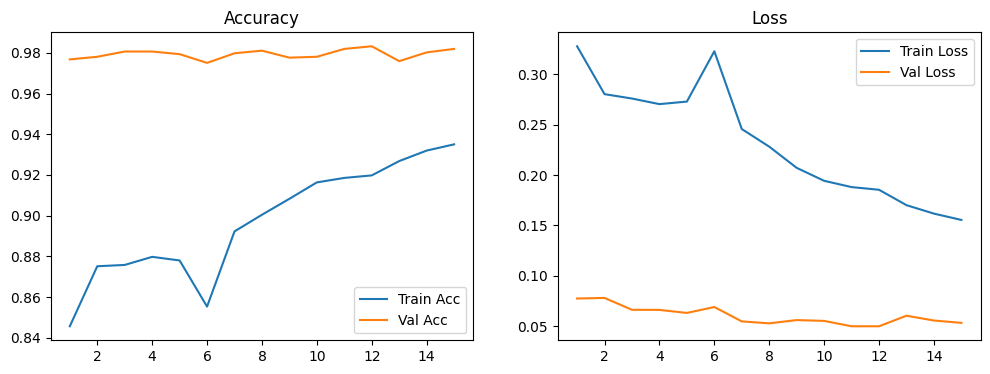

In [20]:
# Helper to merge histories
def plot_training(history1, history2=None):
    acc = history1.history['accuracy']
    val_acc = history1.history['val_accuracy']
    loss = history1.history['loss']
    val_loss = history1.history['val_loss']

    # ✅ Merge second history if provided
    if history2 is not None:
        acc += history2.history['accuracy']
        val_acc += history2.history['val_accuracy']
        loss += history2.history['loss']
        val_loss += history2.history['val_loss']

    epochs_range = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Train Acc')
    plt.plot(epochs_range, val_acc, label='Val Acc')
    plt.legend()
    plt.title('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Train Loss')
    plt.plot(epochs_range, val_loss, label='Val Loss')
    plt.legend()
    plt.title('Loss')

    plt.show()

# Call with both histories (head training + fine-tuning)
plot_training(history_head, history_fine)


10. Evaluate on test set & produce confusion matrix

73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.9874 - loss: 0.0347
Test loss: 0.0365, Test accuracy: 0.9871
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step

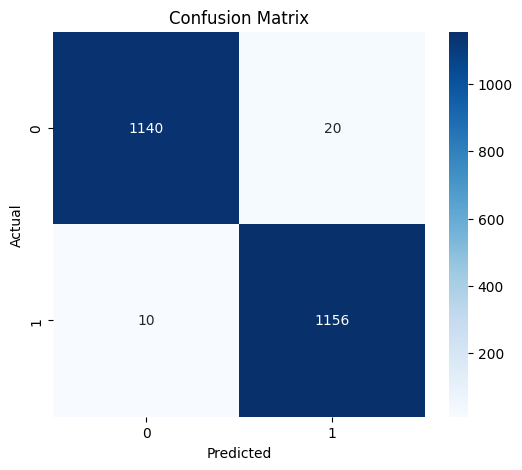

In [21]:
# Evaluate
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test loss: {test_loss:.4f}, Test accuracy: {test_acc:.4f}")


# Predictions & ground-truth collection
y_true = []
y_pred = []
for images, labels in test_ds:
  preds = model.predict(images)
  preds = (preds > 0.5).astype('int32').flatten().tolist()
  y_pred.extend(preds)
  y_true.extend(labels.numpy().astype('int32').tolist())


# Confusion matrix & classification report
cm = confusion_matrix(y_true, y_pred)
print('Classification Report:\n', classification_report(y_true, y_pred))


# Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

11. Save final model & artifacts

In [22]:
model.save('transfer_mobilenetv2_final.h5')
print('Saved model: transfer_mobilenetv2_final.h5')
# training_log.csv saved by CSVLogger; best model saved by ModelCheckpoint

Saved model: transfer_mobilenetv2_final.h5


12. Gradio app code

In [28]:
import gradio as gr
import numpy as np
from tensorflow.keras.models import load_model
from PIL import Image
import requests
from io import BytesIO

# Load saved model
model = load_model("transfer_mobilenetv2_final.h5")

# Define class labels
class_names = ["Cat", "Dog"]

# Preprocess function
def preprocess(img):
    img = img.resize((224, 224))  # match MobileNetV2 input size
    img_array = np.array(img) / 255.0
    return np.expand_dims(img_array, axis=0)

# Prediction function (handles both sigmoid & softmax cases)
def predict(img):
    img_array = preprocess(img)
    preds = model.predict(img_array)

    if preds.shape[1] == 1:  # Binary classification (sigmoid)
        prob = float(preds[0][0])
        probs = {class_names[0]: 1 - prob, class_names[1]: prob}
        pred_class = class_names[1] if prob > 0.5 else class_names[0]
        confidence = prob if prob > 0.5 else 1 - prob
    else:  # Categorical classification (softmax)
        probs = {class_names[i]: float(preds[0][i]) for i in range(len(class_names))}
        pred_class = class_names[np.argmax(preds)]
        confidence = float(np.max(preds))

    return probs, f"✅ Prediction: {pred_class} ({confidence:.2%})"

# Example images (direct URLs that work with PIL)
example_urls = [
    "https://raw.githubusercontent.com/microsoft/ComputerVision/main/datasets/cats_and_dogs/test/cat.jpg",
    "https://raw.githubusercontent.com/microsoft/ComputerVision/main/datasets/cats_and_dogs/test/dog.jpg"
]

examples = []
for url in example_urls:
    try:
        response = requests.get(url, timeout=10)
        img = Image.open(BytesIO(response.content)).convert("RGB")
        examples.append(img)
    except Exception as e:
        print(f"⚠️ Could not load example {url}: {e}")

# Build Gradio app
demo = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="pil", label="Upload an Image"),
    outputs=[gr.Label(num_top_classes=2, label="Probabilities"),
             gr.Textbox(label="Result")],
    title="🐶🐱 Cat vs Dog Classifier (Transfer Learning)",
    description="Upload an image or click an example to classify it using a fine-tuned MobileNetV2 model.",
    examples=examples
)

demo.launch(debug=True)


⚠️ Could not load example https://raw.githubusercontent.com/microsoft/ComputerVision/main/datasets/cats_and_dogs/test/cat.jpg: cannot identify image file <_io.BytesIO object at 0x78d29d4c6e30>
⚠️ Could not load example https://raw.githubusercontent.com/microsoft/ComputerVision/main/datasets/cats_and_dogs/test/dog.jpg: cannot identify image file <_io.BytesIO object at 0x78d29bef84f0>
It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://df79303c9cdabeabd0.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/gradio/queueing.py", line 626, in process_events
    response = await route_utils.call_process_api(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/gradio/route_utils.py", line 350, in call_process_api
    output = await app.get_blocks().process_api(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/gradio/blocks.py", line 2250, in process_api
    result = await self.call_function(
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/gradio/blocks.py", line 1757, in call_function
    prediction = await anyio.to_thread.run_sync(  # type: ignore
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/anyio/to_thread.py", line 56, in run_sync
    return await get_async_backend().run_sync_in_worker_thread(
           ^^^^^

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://b6b6cc8da21a0ff343.gradio.live
Killing tunnel 127.0.0.1:7862 <> https://9f3c25bf5cbb1df215.gradio.live
Killing tunnel 127.0.0.1:7863 <> https://df79303c9cdabeabd0.gradio.live


13. Installing Packages for Streamlit App

In [41]:
!pip install streamlit
!pip install pyngrok   # (optional if you want to run Streamlit inside Colab with a public URL)


14. Ngrok Token

In [42]:
!ngrok config add-authtoken YOUR_TOKEN_HERE

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


15. Streamlit Code

In [43]:
with open("streamlit_app.py", "w") as f:
    f.write("""
import streamlit as st
from PIL import Image, ImageOps
import numpy as np
import tensorflow as tf

# Load model
@st.cache_resource
def load_model():
    return tf.keras.models.load_model("transfer_mobilenetv2_final.h5")

model = load_model()

# Preprocessing function
def preprocess_image(image):
    image = image.resize((224, 224))
    image = ImageOps.fit(image, (224, 224), Image.Resampling.LANCZOS)
    img_array = np.array(image) / 255.0
    return np.expand_dims(img_array, axis=0)

# Prediction function
def predict(image):
    processed = preprocess_image(image)
    preds = model.predict(processed)
    class_names = ["Cat", "Dog"]
    return class_names[int(preds[0] > 0.5)]

# Streamlit app
def main():
    st.title("🐱🐶 Cat vs Dog Classifier")
    st.write("Upload an image and the model will predict whether it’s a **cat** or a **dog**.")

    uploaded_file = st.file_uploader("Upload an image", type=["jpg", "jpeg", "png"])
    if uploaded_file is not None:
        image = Image.open(uploaded_file).convert("RGB")
        st.image(image, caption="Uploaded Image", use_container_width=True)

        if st.button("Predict"):
            label = predict(image)
            st.success(f"Prediction: **{label}**")

if __name__ == "__main__":
    main()
""")


16. Run Streamlit app

In [44]:
from pyngrok import ngrok

# Kill any existing tunnels
ngrok.kill()

# Start a new tunnel on port 8501
public_url = ngrok.connect(8501)
print("🌍 Public URL:", public_url)

# Run streamlit in background
!streamlit run streamlit_app.py --server.port 8501 &> /dev/null &


🌍 Public URL: NgrokTunnel: "https://958c51eaf8d0.ngrok-free.app" -> "http://localhost:8501"
